In [2]:
from evds import evdsAPI
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

True

In [ ]:
# GENEL PROJE NOTLARI

# 1-) EVDS’te ilgili serileri indirdikten sonra gecikme etkileri
# (lag) ekleyerek regresyon ya da VAR tarzı modellerle denenmelidir.

In [ ]:
# EVDS Data Analysis
# Economic Data Service API analysis for USD and EUR exchange rates

# Get API key from environment variable
api_key = os.getenv('EVDS_API_KEY')
if not api_key:
    raise ValueError("EVDS_API_KEY not found in environment variables")

# Initialize EVDS API
evds = evdsAPI(api_key)

# Get USD and EUR exchange rate data
data = evds.get_data(['TP.DK.USD.A.YTL','TP.DK.EUR.A.YTL'], 
                     startdate="01-01-2019", 
                     enddate="01-01-2020")

issiszlik_data = evds.get_data(['TP.ISGUCARSIV.G7'], # Bu veri 2021 den sonra mevcut değil.
                     startdate="01-01-2017", 
                     enddate="01-01-2018")

print("\nFirst 5 rows:")
print("Data shape:", issiszlik_data.shape)
print("Issiszlik data shape:\n ", issiszlik_data.head(), "\n", issiszlik_data.tail())
print("Data shape:", data.shape)
print("Dolar Euro shape:\n " ,data.head(), "\n", data.tail())



First 5 rows:
Data shape: (13, 2)
Issiszlik data shape:
      Tarih  TP_ISGUCARSIV_G7
0  2017-1              13.0
1  2017-2              12.6
2  2017-3              11.7
3  2017-4              10.5
4  2017-5              10.2 
       Tarih  TP_ISGUCARSIV_G7
8    2017-9              10.6
9   2017-10              10.3
10  2017-11              10.3
11  2017-12              10.4
12   2018-1              10.8
Data shape: (365, 3)
Dolar Euro shape:
          Tarih  TP_DK_USD_A_YTL  TP_DK_EUR_A_YTL
0  02-01-2019           5.2810           6.0422
1  03-01-2019           5.3316           6.1061
2  04-01-2019           5.4588           6.2057
3  05-01-2019              NaN              NaN
4  06-01-2019              NaN              NaN 
           Tarih  TP_DK_USD_A_YTL  TP_DK_EUR_A_YTL
360  28-12-2019              NaN              NaN
361  29-12-2019              NaN              NaN
362  30-12-2019           5.9370           6.6117
363  31-12-2019           5.9402           6.6506
364  01-01

In [31]:
print(data.isna().sum()) # Tatil günleri ve hafta sonu tatilleri boş veriler ile dolu.

# En mantıklı doldurma yöntemi forward fill, backward fill olacak.

data_ffill = data.ffill() 
data_completed = data_ffill.bfill()

print(data_completed.isna().sum())

nan_usd = data[data['TP_DK_USD_A_YTL'].isna()]

print(nan_usd)


Tarih                0
TP_DK_USD_A_YTL    116
TP_DK_EUR_A_YTL    116
dtype: int64
Tarih              0
TP_DK_USD_A_YTL    0
TP_DK_EUR_A_YTL    0
dtype: int64
          Tarih  TP_DK_USD_A_YTL  TP_DK_EUR_A_YTL
3    05-01-2019              NaN              NaN
4    06-01-2019              NaN              NaN
10   12-01-2019              NaN              NaN
11   13-01-2019              NaN              NaN
17   19-01-2019              NaN              NaN
..          ...              ...              ...
353  21-12-2019              NaN              NaN
354  22-12-2019              NaN              NaN
360  28-12-2019              NaN              NaN
361  29-12-2019              NaN              NaN
364  01-01-2020              NaN              NaN

[116 rows x 3 columns]


<Figure size 640x480 with 0 Axes>

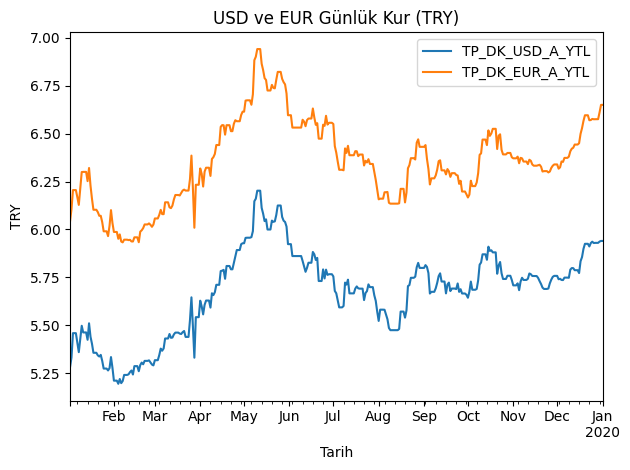

In [33]:
# We will plot the correct graphs to see the relationship between the variables.

data_completed['Tarih'] = pd.to_datetime(data_completed['Tarih'], dayfirst=True, format='%d-%m-%Y')
data_completed = data_completed.set_index('Tarih').sort_index()

data_completed_interp = data_completed.interpolate(method='linear')

# 3) USD & EUR kuru grafiği
plt.figure()
data_completed_interp[['TP_DK_USD_A_YTL', 'TP_DK_EUR_A_YTL']].plot()
plt.title('USD ve EUR Günlük Kur (TRY)')
plt.xlabel('Tarih')
plt.ylabel('TRY')
plt.tight_layout()
plt.show()